In [ ]:
import os
import zipfile
import shutil

# Path to the MegaDepth dataset
megadepth_root = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2"
folders_to_download = sorted(os.listdir(megadepth_root))[:5]  # Select first 5 folders
temp_copy_path = "/kaggle/working/megadepth_subset"

# Step 1: Copy selected folders to /kaggle/working/megadepth_subset
os.makedirs(temp_copy_path, exist_ok=True)

for folder in folders_to_download:
    src = os.path.join(megadepth_root, folder)
    dst = os.path.join(temp_copy_path, folder)
    shutil.copytree(src, dst)

# Step 2: Zip the selected folders
zip_path = "/kaggle/working/megadepth_subset.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(temp_copy_path):
        for file in files:
            abs_path = os.path.join(root, file)
            rel_path = os.path.relpath(abs_path, temp_copy_path)
            zipf.write(abs_path, arcname=rel_path)

print(f"Zipped 5 folders successfully! You can download it from: {zip_path}")


In [ ]:
!pip install segment_anything

In [ ]:
!pip install scikit-image

In [ ]:
import numpy as np
import networkx as nx
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from scipy.optimize import minimize

In [ ]:
import os
import random
from pathlib import Path

# Base dataset directory
root_dir = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2"

# Get list of all folder names (0015, 0022, etc.)
all_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])

# Select only 8 folders (either randomly or first 8)
selected_folders = all_folders[:5]  # or use random.sample(all_folders, 8)

# Collect image and depth file paths
selected_data = []

for folder in selected_folders:
    image_folder = os.path.join(root_dir, folder, "dense0", "imgs")
    depth_folder = os.path.join(root_dir, folder, "dense0", "depths")

    if os.path.exists(image_folder) and os.path.exists(depth_folder):
        for image_file in os.listdir(image_folder):
            if image_file.endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(image_folder, image_file)

                # Replace extension with .h5 to find matching depth file
                depth_filename = Path(image_file).stem + ".h5"
                depth_path = os.path.join(depth_folder, depth_filename)

                if os.path.exists(depth_path):
                    selected_data.append((image_path, depth_path))

print(f"Selected {len(selected_data)} image-depth pairs from 5 folders.")


# Segmentation

In [ ]:
import cv2
import numpy as np
import h5py
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the MegaDepth dataset image and depth map
def load_megadepth_image(image_path, depth_path):
    """Loads an image and its corresponding depth map from MegaDepth dataset."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Ensure image is uint8 for SAM
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    # Load depth map from .h5 file
    with h5py.File(depth_path, 'r') as f:
        depth = np.array(f["depth"])

    return image, depth

# Initialize the SAM model with the correct checkpoint
def initialize_sam(model_path):
    """Initializes the Segment Anything Model (SAM)."""
    sam = sam_model_registry["vit_h"](checkpoint=model_path)
    sam_mask_generator = SamAutomaticMaskGenerator(sam)
    return sam_mask_generator

# Get segmentation masks using SAM
def segment_image(image, sam_mask_generator):
    """Generates segmentation masks using SAM."""

    # Ensure correct dtype
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    masks = sam_mask_generator.generate(image)

    # Filter out empty masks (segmentation all False)
    valid_masks = [m for m in masks if np.any(m["segmentation"])]

    return valid_masks


# MRG

In [ ]:
import networkx as nx
import numpy as np

def construct_mrg2(masks):
    G = nx.Graph()

    # Add nodes
    for idx, mask in enumerate(masks):
        G.add_node(idx, mask=mask["segmentation"])

    print(f"Total Nodes: {G.number_of_nodes()}")  # Debugging

    # Define edges based on adjacency & depth similarity
    for i, mask_i in enumerate(masks):
        for j, mask_j in enumerate(masks):
            if i != j:
                # Ensure boolean masks
                mask_i_bin = mask_i["segmentation"] > 0
                mask_j_bin = mask_j["segmentation"] > 0

                # IoU Calculation
                intersection = np.logical_and(mask_i_bin, mask_j_bin).sum()
                union = np.logical_or(mask_i_bin, mask_j_bin).sum()
                iou = intersection / union if union != 0 else 0

                # Depth Similarity
                depth_diff = np.abs(mask_i.get("depth_mean", 0) - mask_j.get("depth_mean", 0))
                depth_similarity = np.exp(-depth_diff / 10)  # Adjust scaling factor

                weight = iou * depth_similarity

                # Lower threshold & debug
                if weight > 0.1:
                    print(f"Edge: {i} - {j}, Weight: {weight}")
                    G.add_edge(i, j, weight=weight)

    print(f"Total Edges: {G.number_of_edges()}")  # Debugging
    return G


# AMRF

In [ ]:
import networkx as nx
import numpy as np

def construct_amrf(masks, lambda_param=10):
    """
    Constructs an Area Markov Random Field (AMRF) using IoU and depth similarity.
    This extends construct_mrg2() by defining MRF energy functions but does NOT solve it.
    """
    G = nx.Graph()

    # Add nodes (each segment as a node)
    for idx, mask in enumerate(masks):
        G.add_node(idx, mask=mask["segmentation"], depth_mean=mask.get("depth_mean", 0))

    print(f"Total Nodes: {G.number_of_nodes()}")  # Debugging

    # Define edges with MRF-based weights
    for i, mask_i in enumerate(masks):
        for j, mask_j in enumerate(masks):
            if i < j:  # Avoid duplicate edges
                # Ensure boolean masks
                mask_i_bin = mask_i["segmentation"] > 0
                mask_j_bin = mask_j["segmentation"] > 0

                # Compute IoU
                intersection = np.logical_and(mask_i_bin, mask_j_bin).sum()
                union = np.logical_or(mask_i_bin, mask_j_bin).sum()
                iou = intersection / union if union != 0 else 0

                # Depth similarity
                depth_diff = np.abs(mask_i.get("depth_mean", 0) - mask_j.get("depth_mean", 0))
                depth_similarity = np.exp(-depth_diff / 10)  # Scaling factor

                # Pairwise MRF energy function (Spatial Smoothness)
                weight = lambda_param * iou * depth_similarity

                # Lower threshold for meaningful edges
                if weight > 0.1:
                    print(f"Edge: {i} - {j}, Weight: {weight}")
                    G.add_edge(i, j, weight=weight)

    print(f"Total Edges: {G.number_of_edges()}")  # Debugging
    return G



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_amrf(G):
    """
    Visualizes the Area Markov Random Field (AMRF) graph.
    - Nodes are colored based on depth.
    - Edge thickness represents weights.
    """
    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

    # Extract node depth values
    depths = np.array([G.nodes[n]["depth_mean"] for n in G.nodes()])

    # Normalize depth values for colormap
    min_depth, max_depth = depths.min(), depths.max()
    depth_colors = (depths - min_depth) / (max_depth - min_depth + 1e-6)  # Normalize to [0,1]

    # Draw nodes with color mapping
    cmap = plt.get_cmap("coolwarm")
    node_colors = [cmap(val) for val in depth_colors]

    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos, with_labels=True, node_size=500, node_color=node_colors,
        cmap=cmap, edge_color="gray", font_size=10, font_weight="bold"
    )

    # Draw edge weights
    edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Area Markov Random Field (AMRF) Graph")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="Normalized Depth")
    plt.show()


# GraphCut

In [ ]:
!pip install PyMaxflow

In [ ]:
import networkx as nx
import numpy as np
import maxflow  # PyMaxflow library

import numpy as np
from skimage.transform import resize

def compute_iou(mask1, mask2):
    """Computes Intersection over Union (IoU) between two segmentation masks."""

    # Ensure masks have the same shape
    if mask1.shape != mask2.shape:
        min_height = min(mask1.shape[0], mask2.shape[0])
        min_width = min(mask1.shape[1], mask2.shape[1])

        mask1 = resize(mask1.astype(float), (min_height, min_width), anti_aliasing=False) > 0.5
        mask2 = resize(mask2.astype(float), (min_height, min_width), anti_aliasing=False) > 0.5

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def apply_graph_cut(G1, G2):
    """
    Applies Graph Cut algorithm to match areas between two AMRF graphs.

    Args:
        G1 (nx.Graph): AMRF graph for Image 1.
        G2 (nx.Graph): AMRF graph for Image 2.

    Returns:
        matched_areas (list): List of matched area indices.
    """
    num_nodes1 = G1.number_of_nodes()
    num_nodes2 = G2.number_of_nodes()

    if num_nodes1 == 0 or num_nodes2 == 0:
        print("Error: One of the graphs is empty!")
        return []

    # Create a max-flow graph
    graph = maxflow.Graph[float]()
    node_ids1 = graph.add_nodes(num_nodes1)
    node_ids2 = graph.add_nodes(num_nodes2)

    # Add intra-graph edges (inside G1 and G2)
    for G, node_ids in zip([G1, G2], [node_ids1, node_ids2]):
        for i, j, data in G.edges(data=True):
            weight = data['weight']
            graph.add_edge(node_ids[i], node_ids[j], weight, weight)  # Bi-directional

    # Compute depth standard deviation for normalization
    all_depths = [G1.nodes[n]["depth_mean"] for n in G1.nodes] + [G2.nodes[n]["depth_mean"] for n in G2.nodes]
    depth_std = np.std(all_depths)

    # Add inter-graph edges (matching areas between G1 and G2)
    for i in G1.nodes:
        for j in G2.nodes:
            iou = compute_iou(G1.nodes[i]["mask"], G2.nodes[j]["mask"])
            depth_diff = abs(G1.nodes[i]["depth_mean"] - G2.nodes[j]["depth_mean"])
            depth_similarity = np.exp(-depth_diff / (depth_std + 1e-6))  # Normalize depth

            final_similarity = (iou * 0.7) + (depth_similarity * 0.3)  # Weighted combination

            if final_similarity > 0.2:  # Threshold
                graph.add_edge(node_ids1[i], node_ids2[j], final_similarity, final_similarity)

    # Add source/sink links for segmentation
    for i in range(num_nodes1):
        neighbor_weights = [G1.edges[i, j]['weight'] for j in G1.neighbors(i)] if len(list(G1.neighbors(i))) > 0 else [0]
        similarity = np.mean(neighbor_weights) / max(neighbor_weights, default=1)  # Normalize
        graph.add_tedge(node_ids1[i], similarity, 1 - similarity)

    for i in range(num_nodes2):
        neighbor_weights = [G2.edges[i, j]['weight'] for j in G2.neighbors(i)] if len(list(G2.neighbors(i))) > 0 else [0]
        similarity = np.mean(neighbor_weights) / max(neighbor_weights, default=1)  # Normalize
        graph.add_tedge(node_ids2[i], similarity, 1 - similarity)

    # Compute the min-cut
    graph.maxflow()

    # Extract matched areas (areas assigned to the same segment)
    matched_areas = [(i, j) for i in range(num_nodes1) for j in range(num_nodes2) if graph.get_segment(node_ids1[i]) == graph.get_segment(node_ids2[j])]

    print(f"Matched Areas Count: {len(matched_areas)}")
    return matched_areas


In [ ]:
import numpy as np
import os
import h5py
from PIL import Image
from tqdm import tqdm
import concurrent.futures
import cv2

# Initialize SAM once
model_path = "/kaggle/input/sam_model/other/default/1/sam_vit_h_4b8939.pth"
sam_mask_generator = initialize_sam(model_path)

# Store graphs
all_area_graphs = []
all_amrf_graphs = []

def load_image_and_depth(image_path, depth_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    with h5py.File(depth_path, "r") as f:
        depth = np.array(f["depth"])
    return image, depth

def process_pair(image_path, depth_path):
    try:
        image, depth = load_megadepth_image(image_path, depth_path)

        # Resize depth if necessary
        if depth.shape != image.shape[:2]:
            depth = cv2.resize(depth, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Segment using SAM
        masks = segment_image(image, sam_mask_generator)

        # Check masks
        if not masks:
            print(f"[WARNING] No masks found for {os.path.basename(image_path)}")
            return None, None

        for mask in masks:
            mask_coords = np.where(mask["segmentation"])
            mask["depth_mean"] = float(np.mean(depth[mask_coords])) if mask_coords[0].size > 0 else 0.0

        area_graph = construct_mrg2(masks)
        amrf_graph = construct_amrf(masks)

        return area_graph, amrf_graph

    except Exception as e:
        print(f"[ERROR] {os.path.basename(image_path)}: {e}")
        return None, None

# Parallel processing: one image-depth pair per thread
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(process_pair, img_path, d_path) for img_path, d_path in selected_data]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Images"):
        area_graph, amrf_graph = future.result()
        if area_graph is not None:
            all_area_graphs.append(area_graph)
            all_amrf_graphs.append(amrf_graph)


In [ ]:
print(all_area_graphs)

# Siamese Training

In [ ]:
import os
import shutil
import pickle

# Paths
pkl_folder = '/kaggle/input/area-graph/sample_area_graph/'
megadepth_root = '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/'
output_folder = '/kaggle/working/matched_images/'  # Output folder (new)

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Step 1: Read all pkl filenames (without extension)
pkl_files = [f for f in os.listdir(pkl_folder) if f.endswith('_area_graph.pkl')]
image_base_names = [os.path.splitext(f)[0].replace('_area_graph', '') for f in pkl_files]

print(f"Total PKL files found: {len(image_base_names)}")

# Step 2: Search for each corresponding image in the megadepth folder
# We'll walk through all 'images' folders under megadepth_root
for root, dirs, files in os.walk(megadepth_root):
    if os.path.basename(root) == 'images':  # Only look inside 'images' folders
        for img_file in files:
            img_name, ext = os.path.splitext(img_file)
            if img_name in image_base_names:
                src_path = os.path.join(root, img_file)
                dst_path = os.path.join(output_folder, img_file)
                shutil.copy2(src_path, dst_path)
                print(f"Copied: {img_file}")

print("Done copying matched images!")


Total PKL files found: 6
Done copying matched images!


In [ ]:
import os
import shutil

# List of full source file paths
source_files = [
    '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1170885856_497274104b_o.jpg',
    '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/152265952_c8b3d72337_o.jpg',
    '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/205952007_62674a854f_o.jpg',
    '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/2163367105_090a4a24b7_o.jpg',
    '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/2861794455_6fdb683022_o.jpg',
    '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/2090585891_ea287a4157_o.jpg'
]

# Destination folder where you want to copy
destination_folder = '/kaggle/working/sample_images/'

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy each file
for src_path in source_files:
    if os.path.exists(src_path):
        shutil.copy2(src_path, destination_folder)
        print(f"Copied: {os.path.basename(src_path)}")
    else:
        print(f"File not found: {src_path}")

print("All copying done!")


Copied: 1170885856_497274104b_o.jpg
Copied: 152265952_c8b3d72337_o.jpg
Copied: 205952007_62674a854f_o.jpg
Copied: 2163367105_090a4a24b7_o.jpg
Copied: 2861794455_6fdb683022_o.jpg
Copied: 2090585891_ea287a4157_o.jpg
All copying done!


# Generating Pairs

In [ ]:
import os
import random

# Input folder with copied images
dataset_path = "/kaggle/working/sample_images"
output_pairs_file = "/kaggle/working/pairs.txt"

# List all images
images = sorted(os.listdir(dataset_path))

pairs = []

# Create positive pairs (same folder, any two images)
for _ in range(len(images) // 2):
    img1, img2 = random.sample(images, 2)
    pairs.append(f"{img1} {img2} 1")  # Label 1 for positive pair

# Create negative pairs (simulate different scenes by choosing different images)
for _ in range(len(images) // 2):
    img1, img2 = random.sample(images, 2)
    pairs.append(f"{img1} {img2} 0")  # Label 0 for negative pair

# Save pairs to file
with open(output_pairs_file, "w") as f:
    f.write("\n".join(pairs))

print(f"Generated {len(pairs)} pairs and saved to {output_pairs_file}")


Generated 6 pairs and saved to /kaggle/working/pairs.txt


In [ ]:
import os
import random
import itertools

dataset_path = "/kaggle/working/sample_images"
output_pairs_file = "/kaggle/working/all_pairs.txt"

images = sorted(os.listdir(dataset_path))
pairs = []

# --- Generate all positive pairs ---
positive_pairs = list(itertools.combinations(images, 2))  # all unique pairs
print(f"Total positive pairs: {len(positive_pairs)}")

# Randomly sample positives if too many (optional)
# positive_pairs = random.sample(positive_pairs, min(len(positive_pairs), 100))

for img1, img2 in positive_pairs:
    pairs.append(f"{img1} {img2} 1")

# --- Generate negative pairs (by shuffling) ---
# In absence of scenes, simulate negatives randomly
for _ in range(len(positive_pairs)):
    img1, img2 = random.sample(images, 2)
    pairs.append(f"{img1} {img2} 0")

# Save pairs
with open(output_pairs_file, "w") as f:
    f.write("\n".join(pairs))

print(f"Generated {len(pairs)} pairs and saved to {output_pairs_file}")


Total positive pairs: 15
Generated 30 pairs and saved to /kaggle/working/all_pairs.txt


# Siamese Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

# Define Contrastive Loss
def contrastive_loss(distance, label, margin=1.0):
    loss = label * torch.pow(distance, 2) + (1 - label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    return torch.mean(loss)

# Define Siamese Dataset that uses pairs.txt
class SiameseDataset(Dataset):
    def __init__(self, pairs_file, root_folder, transform=None):
        self.pairs = []
        self.root_folder = root_folder
        self.transform = transform

        with open(pairs_file, "r") as f:
            for line in f:
                img1, img2, label = line.strip().split()
                self.pairs.append((img1, img2, int(label)))

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]
        img1 = Image.open(os.path.join(self.root_folder, img1_path)).convert("L")
        img2 = Image.open(os.path.join(self.root_folder, img2_path)).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor([float(label)], dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((400, 296)),
    transforms.ToTensor()
])


In [ ]:
# optimised siamese network
# with batch normalisation, dropout and Smaller Feature Map

import torch
import torch.nn as nn
import torch.nn.functional as F

class OptimizedSiameseNetwork(nn.Module):
    def __init__(self, input_size=(400, 296)):
        super(OptimizedSiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batch Norm speeds up convergence
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((4, 4))  # Reducing final feature size for efficiency
        )

        # Compute flattened size dynamically
        sample_input = torch.zeros(1, 1, *input_size)
        sample_output = self.cnn(sample_input)
        flattened_size = sample_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(512, 128)  # Smaller embedding size for efficiency
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = F.pairwise_distance(output1, output2, keepdim=True)  # Keep dim for easy FC processing
        return distance


In [ ]:
# Load dataset from pairs.txt
dataset = SiameseDataset("/kaggle/working/all_pairs.txt", "/kaggle/working/sample_images", transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=8)

# Load Siamese Model
model = OptimizedSiameseNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 30
for epoch in range(epochs):
    total_loss = 0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        distance = model(img1, img2)
        loss = contrastive_loss(distance, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

print("Training Complete!")

Epoch [1/30], Loss: 22.0347
Epoch [2/30], Loss: 1.6567
Epoch [3/30], Loss: 0.5327
Epoch [4/30], Loss: 0.3567
Epoch [5/30], Loss: 0.4297
Epoch [6/30], Loss: 0.5724
Epoch [7/30], Loss: 0.4504
Epoch [8/30], Loss: 0.4032
Epoch [9/30], Loss: 0.3933
Epoch [10/30], Loss: 0.4182
Epoch [11/30], Loss: 0.4304
Epoch [12/30], Loss: 0.4255
Epoch [13/30], Loss: 0.3968
Epoch [14/30], Loss: 0.3709
Epoch [15/30], Loss: 0.4731
Epoch [16/30], Loss: 0.2575
Epoch [17/30], Loss: 0.3631
Epoch [18/30], Loss: 0.5337
Epoch [19/30], Loss: 0.4123
Epoch [20/30], Loss: 0.4098
Epoch [21/30], Loss: 0.4429
Epoch [22/30], Loss: 0.4594
Epoch [23/30], Loss: 0.3738
Epoch [24/30], Loss: 0.4814
Epoch [25/30], Loss: 0.4017
Epoch [26/30], Loss: 0.3735
Epoch [27/30], Loss: 0.4150
Epoch [28/30], Loss: 0.3517
Epoch [29/30], Loss: 0.4543
Epoch [30/30], Loss: 0.3819
Training Complete!


# After Train Test Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import os

class SiameseDataset(Dataset):
    def __init__(self, pairs=None, images_dir=None, transform=None):
        self.pairs = pairs  # List of pairs passed directly
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1, img2, label = self.pairs[idx]
        img1_path = os.path.join(self.images_dir, img1)
        img2_path = os.path.join(self.images_dir, img2)
        img1 = Image.open(img1_path).convert("L")
        img2 = Image.open(img2_path).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import os

# Load pairs from file
def load_pairs(pairs_file):
    pairs = []
    with open(pairs_file, 'r') as f:
        for line in f.readlines():
            img1, img2, label = line.strip().split()
            pairs.append((img1, img2, int(label)))
    return pairs

# Path to pairs.txt and images directory
pairs_file = "/kaggle/working/all_pairs.txt"
images_dir = "/kaggle/working/sample_images"

# Load all pairs
all_pairs = load_pairs(pairs_file)

# Split into train and test datasets
train_pairs, test_pairs = train_test_split(all_pairs, test_size=0.2, random_state=42)

# Create the datasets using the train and test pairs directly
train_dataset = SiameseDataset(pairs=train_pairs, images_dir=images_dir, transform=transform)
test_dataset = SiameseDataset(pairs=test_pairs, images_dir=images_dir, transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=8)

# Load Siamese Model
model = OptimizedSiameseNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()  # Ensure model is in training mode
    total_loss = 0
    for img1, img2, label in train_dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        distance = model(img1, img2)
        loss = contrastive_loss(distance, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_dataloader):.4f}")

print("Training Complete!")

Epoch [1/10], Loss: 17.4334
Epoch [2/10], Loss: 1.0933
Epoch [3/10], Loss: 0.3092
Epoch [4/10], Loss: 0.5054
Epoch [5/10], Loss: 0.3561
Epoch [6/10], Loss: 0.4330
Epoch [7/10], Loss: 0.4920
Epoch [8/10], Loss: 0.3981
Epoch [9/10], Loss: 0.4328
Epoch [10/10], Loss: 0.4094
Training Complete!


In [ ]:
# Now let's evaluate on the test set after training
model.eval()  # Set the model to evaluation mode
test_loss = 0
with torch.no_grad():  # No gradient calculation during evaluation
    for img1, img2, label in test_dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        distance = model(img1, img2)
        loss = contrastive_loss(distance, label)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_dataloader):.4f}")


Test Loss: 0.4322


# ROC-AUC

> On Test data

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Collect distances and labels
all_distances = []
all_labels = []

model.eval()
with torch.no_grad():
    for img1, img2, label in test_dataloader:
        img1, img2 = img1.to(device), img2.to(device)
        label = label.to(device)

        distance = model(img1, img2)  # Distance between pairs
        all_distances.append(distance.cpu())
        all_labels.append(label.cpu())

# Concatenate all batches
all_distances = torch.cat(all_distances).numpy()
all_labels = torch.cat(all_labels).numpy()


In [ ]:
all_distances

array([[0.19506308],
       [0.17633641],
       [0.36380485],
       [0.12750073],
       [0.18049629],
       [0.24466951]], dtype=float32)

In [ ]:
all_labels

In [ ]:
# For ROC, we need similarity scores, not distances
# So we can take similarity = -distance (smaller distance means more similar)

similarity_scores = -all_distances

fpr, tpr, thresholds = roc_curve(all_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

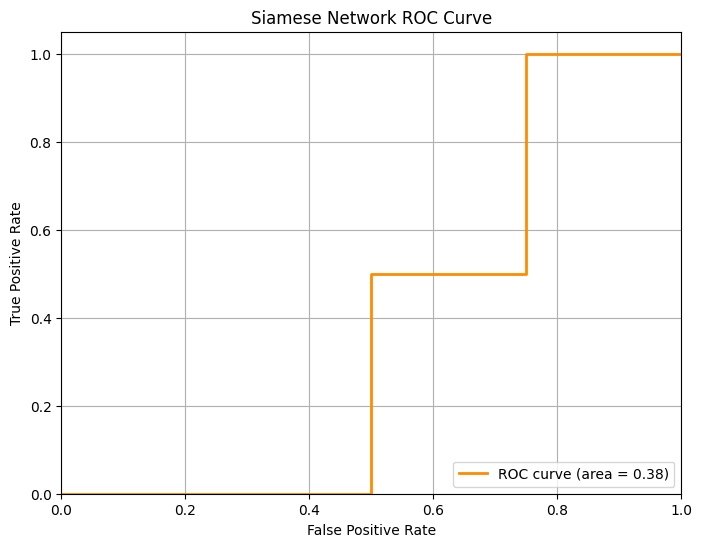

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Siamese Network ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Collect distances and labels
all_distances = []
all_labels = []

model.eval()
with torch.no_grad():
    for img1, img2, label in train_dataloader:
        img1, img2 = img1.to(device), img2.to(device)
        label = label.to(device)

        distance = model(img1, img2)  # Distance between pairs
        all_distances.append(distance.cpu())
        all_labels.append(label.cpu())

# Concatenate all batches
all_distances = torch.cat(all_distances).numpy()
all_labels = torch.cat(all_labels).numpy()


In [ ]:
# For ROC, we need similarity scores, not distances
# So we can take similarity = -distance (smaller distance means more similar)

similarity_scores = -all_distances

fpr, tpr, thresholds = roc_curve(all_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

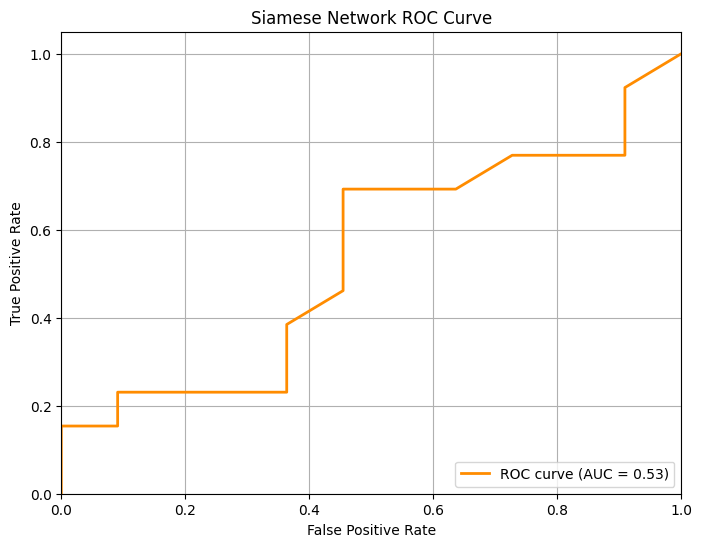

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Siamese Network ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Region Feature Extraction from AMRF Graphs

In [ ]:
from PIL import Image
import numpy as np
import torch

def extract_region_crops(image, amrf_graph, transform=None):
    """
    Given an image and its AMRF graph, extract crops for each node.

    Args:
        image (PIL.Image): Input image.
        amrf_graph (networkx.Graph): Graph with 'mask' in nodes.
        transform: Optional torchvision transform.

    Returns:
        crops (dict): Dictionary {node_idx: crop_tensor}
    """
    crops = {}
    img_np = np.array(image)

    for node_idx, data in amrf_graph.nodes(data=True):
        mask = data["mask"]
        if mask.sum() == 0:
            continue

        coords = np.argwhere(mask)
        ymin, xmin = coords.min(axis=0)
        ymax, xmax = coords.max(axis=0)

        crop = img_np[ymin:ymax+1, xmin:xmax+1]
        crop_img = Image.fromarray(crop)

        if transform:
            crop_img = transform(crop_img)
        else:
            crop_img = transforms.ToTensor()(crop_img)

        crops[node_idx] = crop_img

    return crops


# Siamese Matrix

In [ ]:
def compute_distance_matrix(model, crops1, crops2, device):
    """
    Compute distance matrix between regions from two images.

    Args:
        model: Trained Siamese model.
        crops1 (dict): Node -> crop tensor for image1.
        crops2 (dict): Node -> crop tensor for image2.

    Returns:
        distance_matrix (np.ndarray): (len(crops1), len(crops2)) distance matrix
        node_list1, node_list2: Lists of node indices corresponding to rows and columns
    """
    model.eval()
    node_list1 = list(crops1.keys())
    node_list2 = list(crops2.keys())

    distance_matrix = np.zeros((len(node_list1), len(node_list2)))

    with torch.no_grad():
        for i, n1 in enumerate(node_list1):
            for j, n2 in enumerate(node_list2):
                img1 = crops1[n1].unsqueeze(0).to(device)
                img2 = crops2[n2].unsqueeze(0).to(device)
                dist = model(img1, img2)
                distance_matrix[i, j] = dist.item()

    return distance_matrix, node_list1, node_list2


# Matched Regions

In [ ]:
from scipy.optimize import linear_sum_assignment

def match_regions(distance_matrix):
    """
    Use Hungarian algorithm to find best matching between regions.

    Args:
        distance_matrix (np.ndarray): Distance matrix.

    Returns:
        matches (list of (i, j)): Matched indices.
    """
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    matches = list(zip(row_ind, col_ind))
    return matches


# Visualise Bounding Box

In [ ]:
from PIL import ImageDraw

def draw_matched_boxes(image, amrf_graph, matched_nodes, node_list, color="green"):
    """
    Draw bounding boxes around matched regions.

    Args:
        image (PIL.Image): Input image.
        amrf_graph (nx.Graph): Graph.
        matched_nodes (set): Set of node indices that are matched.
        node_list (list): List of node indices (to map index to node id).
        color (str): Bounding box color.

    Returns:
        image: Annotated image.
    """
    img = image.convert("RGB")
    draw = ImageDraw.Draw(img)

    for idx in matched_nodes:
        node_idx = node_list[idx]
        mask = amrf_graph.nodes[node_idx]["mask"]
        coords = np.argwhere(mask)
        if coords.size == 0:
            continue
        ymin, xmin = coords.min(axis=0)
        ymax, xmax = coords.max(axis=0)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)

    return img


In [ ]:
# 1. Load images and AMRF graphs
path1 = '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/2163367105_090a4a24b7_o.jpg'
path2 = '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/152265952_c8b3d72337_o.jpg'

image1 = Image.open(path1).convert("L")
image2 = Image.open(path2).convert("L")

a_path1 = '/kaggle/input/amrf-output/sample_amrf_output/2163367105_090a4a24b7_o_amrf_graph.pkl'
a_path2 = '/kaggle/input/amrf-output/sample_amrf_output/152265952_c8b3d72337_o_amrf_graph.pkl'

# amrf1 = torch.load(a_path1)  # Or use pickle.load()
# amrf2 = torch.load(a_path2)
import pickle

# Open with pickle
with open(a_path1, 'rb') as f:
    amrf1 = pickle.load(f)

with open(a_path2, 'rb') as f:
    amrf2 = pickle.load(f)


# 2. Extract region crops
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

crops1 = extract_region_crops(image1, amrf1, transform)
crops2 = extract_region_crops(image2, amrf2, transform)

# 3. Compute distance matrix
distance_matrix, node_list1, node_list2 = compute_distance_matrix(model, crops1, crops2, device)

# 4. Find best matching
matches = match_regions(distance_matrix)

# 5. Visualize
matched_nodes1 = {i for i, j in matches}
matched_nodes2 = {j for i, j in matches}

image1_with_boxes = draw_matched_boxes(image1, amrf1, matched_nodes1, node_list1, color="green")
image2_with_boxes = draw_matched_boxes(image2, amrf2, matched_nodes2, node_list2, color="blue")

# Show or save
image1_with_boxes.save("/kaggle/working/matched_image1.jpg")
image2_with_boxes.save("/kaggle/working/matched_image2.jpg")


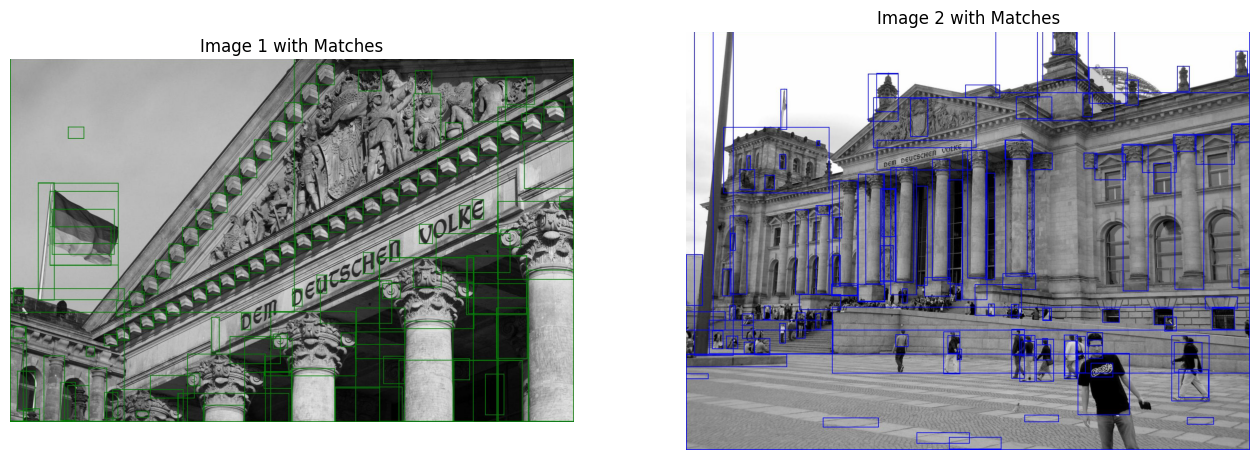

In [ ]:
import matplotlib.pyplot as plt

# Load saved images
matched_img1 = Image.open("/kaggle/working/matched_image1.jpg")
matched_img2 = Image.open("/kaggle/working/matched_image2.jpg")

# Plot side by side
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title("Image 1 with Matches")
plt.imshow(matched_img1)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Image 2 with Matches")
plt.imshow(matched_img2)
plt.axis('off')

plt.show()


# Evaluation Metrics

# Area Overlap Ratio

In [ ]:
import torch.nn.functional as F

def compute_aor(amrf1, amrf2, matches, resize_to=(256, 256)):
    aor_values = []
    for node1_idx, node2_idx in matches:
        mask1 = amrf1.nodes[node1_idx]['mask']  # (H1, W1)
        mask2 = amrf2.nodes[node2_idx]['mask']  # (H2, W2)

        # Convert masks to tensors
        mask1 = torch.tensor(mask1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape (1,1,H,W)
        mask2 = torch.tensor(mask2, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Resize to same size
        mask1 = F.interpolate(mask1, size=resize_to, mode='nearest').squeeze()
        mask2 = F.interpolate(mask2, size=resize_to, mode='nearest').squeeze()

        # Now safe to do AND
        intersection = (mask1.bool() & mask2.bool()).sum().item()
        area1 = mask1.bool().sum().item()
        area2 = mask2.bool().sum().item()

        if min(area1, area2) > 0:
            aor = intersection / min(area1, area2)
            aor_values.append(aor)

    return aor_values


# Area Matching Precision

In [ ]:
def compute_amp(aor_values, thresholds=[0.6, 0.7, 0.8]):
    amp_results = {}
    for t in thresholds:
        num_correct = sum(aor >= t for aor in aor_values)
        precision = num_correct / len(aor_values) if len(aor_values) > 0 else 0
        amp_results[f'AMP@{t}'] = precision
    return amp_results


# Average Area Num

In [ ]:
def compute_average_area_number(amrf1, amrf2):
    num_areas1 = len([n for n in amrf1.nodes if 'mask' in amrf1.nodes[n]])
    num_areas2 = len([n for n in amrf2.nodes if 'mask' in amrf2.nodes[n]])

    area_num = (num_areas1 + num_areas2) / 2
    return area_num


In [ ]:
# After you have 'matches' from match_regions()

# 1. AOR
aor_values = compute_aor(amrf1, amrf2, matches)

# # 2. AMP
amp_results = compute_amp(aor_values)

# 3. AreaNum
area_num = compute_average_area_number(amrf1, amrf2)

print("Area Overlap Ratios (AOR) per match:", aor_values)
print("Area Matching Precision (AMP):", amp_results)
print("Average Area Number (AreaNum):", area_num)


Area Overlap Ratios (AOR) per match: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8906882591093117, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2631578947368421, 0.0, 0.0, 0.0, 0.0, 0.06428571428571428, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Area Matching Precision (AMP): {'AMP@0.6': 0.023622047244094488, 'AMP@0.7': 0.023622047244094488, 'AMP@0.8': 0.023622047244094488}
Average Area Number (AreaNum): 144.0


# Verifying on 2 images

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import os

model = OptimizedSiameseNetwork()

# Load the trained model
model.eval()

# Define a function to test two images
def test_siamese(img1_path, img2_path, model, transform, device):

    # convert("L") converts the images to grayscale (1 channel)
    img1 = Image.open(img1_path).convert("L")
    img2 = Image.open(img2_path).convert("L")

    # .unsqueeze(0) adds a batch dimension → Converts shape from [C, H, W] to [1, C, H, W] (needed for model input)
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)

    # torch.no_grad() disables gradient calculation (saves memory & speeds up inference).
    with torch.no_grad():
        distance = model(img1, img2)

    print(f"Distance between images: {distance.item():.4f}")
    return distance.item()

# Sample image paths from the dataset
# sample_img1 = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1119628220_8328721e8b_o.jpg"
# sample_img2 = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/1125352430_fa4e56275f_o.jpg"

sample_img1 = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0049/dense0/imgs/10025594705_7a1ef6978d_o.jpg"
sample_img2 = "/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0049/dense0/imgs/10358942874_6926b526f1_o.jpg"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = model.to(device)
# model.load_state_dict(torch.load("siamese_model.pth", map_location=device))
# model.eval()

# Run test
test_siamese(sample_img1, sample_img2, model, transform, device)


Distance between images: 0.0413


0.04132447391748428

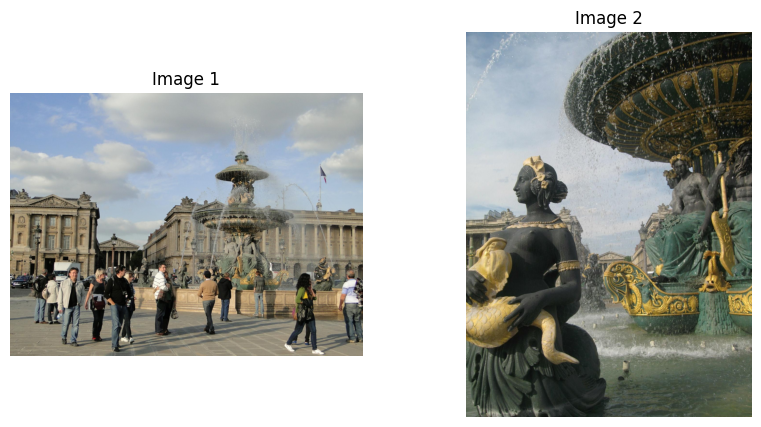

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load images
image1 = cv2.imread(sample_img1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV format) to RGB

image2 = cv2.imread(sample_img2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Image 2")
plt.axis("off")

plt.show()


In [ ]:
import matplotlib.pyplot as plt

def show_images_side_by_side(img1, img2, distance=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title("Image 1")
    axs[0].axis("off")

    axs[1].imshow(img2, cmap='gray')
    axs[1].set_title("Image 2")
    axs[1].axis("off")

    if distance is not None:
        plt.suptitle(f"Siamese Distance: {distance:.4f}", fontsize=14)

    plt.tight_layout()
    plt.show()


In [ ]:
from PIL import ImageDraw

def draw_bounding_boxes_with_matches_nonmatches(image, amrf_graph, matched_indices, is_image1=True):
    """
    Draw bounding boxes for matched and unmatched regions on the image.

    Args:
        image (PIL.Image): The original grayscale image.
        amrf_graph (nx.Graph): Graph containing masks in its nodes.
        matched_indices (list of tuples): List of (i, j) pairs of matched nodes.
        is_image1 (bool): True if this is for image 1, else for image 2.
    Returns:
        PIL.Image: Image with drawn bounding boxes.
    """
    img = image.convert("RGB")
    draw = ImageDraw.Draw(img)

    # Get all node indices in this graph
    all_nodes = set(amrf_graph.nodes)

    # Get matched node indices
    matched_nodes = {i for i, j in matched_indices} if is_image1 else {j for i, j in matched_indices}

    for node_idx in all_nodes:
        mask = amrf_graph.nodes[node_idx]["mask"]
        coords = np.argwhere(mask)
        if coords.size == 0:
            continue
        top_left = tuple(coords.min(axis=0)[::-1])
        bottom_right = tuple(coords.max(axis=0)[::-1])

        # Green if matched, red otherwise
        color = "green" if node_idx in matched_nodes else "red"
        draw.rectangle([top_left, bottom_right], outline=color, width=2)

    return img


In [ ]:
import pickle
import numpy as np
from PIL import ImageDraw
import networkx as nx

def draw_bounding_boxes_with_matches_nonmatches(image, amrf_graph_pkl_path, matched_indices, is_image1=True):
    """
    Draw bounding boxes for matched and unmatched regions on the image.

    Args:
        image (PIL.Image): The original grayscale image.
        amrf_graph_pkl_path (str): Path to the AMRF graph .pkl file (networkx graph).
        matched_indices (list of tuples): List of (i, j) pairs of matched nodes.
        is_image1 (bool): True if this is for image 1, else for image 2.

    Returns:
        PIL.Image: Image with drawn bounding boxes.
    """

    # --- Load the AMRF graph ---
    with open(amrf_graph_pkl_path, 'rb') as f:
        amrf_graph = pickle.load(f)

    img = image.convert("RGB")
    draw = ImageDraw.Draw(img)

    # Get all node indices in this graph
    all_nodes = set(amrf_graph.nodes)

    # Get matched node indices
    matched_nodes = {i for i, j in matched_indices} if is_image1 else {j for i, j in matched_indices}

    for node_idx in all_nodes:
        mask = amrf_graph.nodes[node_idx]["mask"]  # mask is 2D numpy array
        coords = np.argwhere(mask)  # (y,x) locations where mask is True

        if coords.size == 0:
            continue

        # (min_x, min_y) is top-left, (max_x, max_y) is bottom-right
        top_left = tuple(coords.min(axis=0)[::-1])      # (x_min, y_min)
        bottom_right = tuple(coords.max(axis=0)[::-1])   # (x_max, y_max)

        # Green if matched, red if unmatched
        color = "green" if node_idx in matched_nodes else "red"
        draw.rectangle([top_left, bottom_right], outline=color, width=2)

    return img


In [ ]:
from PIL import Image

image = Image.open(sample_img1)

amrf_graph_pkl_path = "/kaggle/working/1170885856_497274104b_o_amrf.pkl"
matched_indices = [(0, 1), (2, 3)]  # example matched pairs

highlighted_image = draw_bounding_boxes_with_matches_nonmatches(image, amrf_graph_pkl_path, matched_indices, is_image1=True)

highlighted_image.show()  # or save

In [ ]:
# img1 and img2: original grayscale PIL images
# amrf_graph1 and amrf_graph2: corresponding graphs
# matched_areas: output from graph cut [(i, j), ...]

# Draw bounding boxes for each image
img1_with_boxes = draw_bounding_boxes_with_matches_nonmatches(img1, amrf_graph1, matched_areas, is_image1=True)
img2_with_boxes = draw_bounding_boxes_with_matches_nonmatches(img2, amrf_graph2, matched_areas, is_image1=False)

# Show side by side with distance if Siamese was used
show_images_side_by_side(img1_with_boxes, img2_with_boxes, distance)


# Siamese on AMRF

In [ ]:
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# Set path to your folder in Google Drive
folder_path = '/kaggle/input/amrf-output/sample_amrf_output'  # change this to your folder

op_path = '/kaggle/working/'
# Make an output directory for images
output_path = os.path.join(op_path, 'images')
os.makedirs(output_path, exist_ok=True)

# Loop over all .pkl files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.pkl'):
        full_path = os.path.join(folder_path, filename)

        # Load the graph
        with open(full_path, 'rb') as f:
            G = pickle.load(f)

        if not isinstance(G, nx.Graph):
            print(f"Skipped {filename}: not a NetworkX graph.")
            continue

        # Plot and save
        plt.figure(figsize=(10, 8))
        nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray',
                node_size=500, font_size=10)

        img_filename = os.path.splitext(filename)[0] + '.png'
        plt.savefig(os.path.join(output_path, img_filename), format='png')
        plt.close()

        print(f"Saved image for {filename}")


Saved image for 1170885856_497274104b_o_amrf_graph.pkl
Saved image for 2163367105_090a4a24b7_o_amrf_graph.pkl
Saved image for 152265952_c8b3d72337_o_amrf_graph.pkl
Saved image for 2090585891_ea287a4157_o_amrf_graph.pkl
Saved image for 205952007_62674a854f_o_amrf_graph.pkl
Saved image for 2861794455_6fdb683022_o_amrf_graph.pkl


In [ ]:
import os
import random
import itertools

dataset_path = "/kaggle/working/images"
output_pairs_file = "/kaggle/working/all_pairs.txt"

images = sorted(os.listdir(dataset_path))
pairs = []

# --- Generate all positive pairs ---
positive_pairs = list(itertools.combinations(images, 2))  # all unique pairs
print(f"Total positive pairs: {len(positive_pairs)}")

# Randomly sample positives if too many (optional)
# positive_pairs = random.sample(positive_pairs, min(len(positive_pairs), 100))

for img1, img2 in positive_pairs:
    pairs.append(f"{img1} {img2} 1")

# --- Generate negative pairs (by shuffling) ---
# In absence of scenes, simulate negatives randomly
for _ in range(len(positive_pairs)):
    img1, img2 = random.sample(images, 2)
    pairs.append(f"{img1} {img2} 0")

# Save pairs
with open(output_pairs_file, "w") as f:
    f.write("\n".join(pairs))

print(f"Generated {len(pairs)} pairs and saved to {output_pairs_file}")


Total positive pairs: 15
Generated 30 pairs and saved to /kaggle/working/all_pairs.txt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

# Define Contrastive Loss
def contrastive_loss(distance, label, margin=1.0):
    loss = label * torch.pow(distance, 2) + (1 - label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    return torch.mean(loss)

# Define Siamese Dataset that uses pairs.txt
class SiameseDataset(Dataset):
    def __init__(self, pairs_file, root_folder, transform=None):
        self.pairs = []
        self.root_folder = root_folder
        self.transform = transform

        with open(pairs_file, "r") as f:
            for line in f:
                img1, img2, label = line.strip().split()
                self.pairs.append((img1, img2, int(label)))

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]
        img1 = Image.open(os.path.join(self.root_folder, img1_path)).convert("L")
        img2 = Image.open(os.path.join(self.root_folder, img2_path)).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor([float(label)], dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((400, 296)),
    transforms.ToTensor()
])


In [ ]:
# optimised siamese network
# with batch normalisation, dropout and Smaller Feature Map

import torch
import torch.nn as nn
import torch.nn.functional as F

class OptimizedSiameseNetwork(nn.Module):
    def __init__(self, input_size=(400, 296)):
        super(OptimizedSiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batch Norm speeds up convergence
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((4, 4))  # Reducing final feature size for efficiency
        )

        # Compute flattened size dynamically
        sample_input = torch.zeros(1, 1, *input_size)
        sample_output = self.cnn(sample_input)
        flattened_size = sample_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(512, 128)  # Smaller embedding size for efficiency
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = F.pairwise_distance(output1, output2, keepdim=True)  # Keep dim for easy FC processing
        return distance


In [ ]:
# Load dataset from pairs.txt
dataset = SiameseDataset("/kaggle/working/all_pairs.txt", "/kaggle/working/images", transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=8)

# Load Siamese Model
model = OptimizedSiameseNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 15
for epoch in range(epochs):
    total_loss = 0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        distance = model(img1, img2)
        loss = contrastive_loss(distance, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

print("Training Complete!")

Epoch [1/15], Loss: 9.2589
Epoch [2/15], Loss: 1.2267
Epoch [3/15], Loss: 0.4974
Epoch [4/15], Loss: 0.4534
Epoch [5/15], Loss: 0.4293
Epoch [6/15], Loss: 0.3554
Epoch [7/15], Loss: 0.3499
Epoch [8/15], Loss: 0.2635
Epoch [9/15], Loss: 0.3885
Epoch [10/15], Loss: 0.2427
Epoch [11/15], Loss: 0.3590
Epoch [12/15], Loss: 0.3146
Epoch [13/15], Loss: 0.4291
Epoch [14/15], Loss: 0.4988
Epoch [15/15], Loss: 0.4270
Training Complete!


In [ ]:
## AOR

import torch.nn.functional as F

def compute_aor(amrf1, amrf2, matches, resize_to=(256, 256)):
    aor_values = []
    for node1_idx, node2_idx in matches:
        mask1 = amrf1.nodes[node1_idx]['mask']  # (H1, W1)
        mask2 = amrf2.nodes[node2_idx]['mask']  # (H2, W2)

        # Convert masks to tensors
        mask1 = torch.tensor(mask1, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape (1,1,H,W)
        mask2 = torch.tensor(mask2, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Resize to same size
        mask1 = F.interpolate(mask1, size=resize_to, mode='nearest').squeeze()
        mask2 = F.interpolate(mask2, size=resize_to, mode='nearest').squeeze()

        # Now safe to do AND
        intersection = (mask1.bool() & mask2.bool()).sum().item()
        area1 = mask1.bool().sum().item()
        area2 = mask2.bool().sum().item()

        if min(area1, area2) > 0:
            aor = intersection / min(area1, area2)
            aor_values.append(aor)

    return aor_values

In [ ]:
## AMP

def compute_amp(aor_values, thresholds=[0.6, 0.7, 0.8]):
    amp_results = {}
    for t in thresholds:
        num_correct = sum(aor >= t for aor in aor_values)
        precision = num_correct / len(aor_values) if len(aor_values) > 0 else 0
        amp_results[f'AMP@{t}'] = precision
    return amp_results

In [ ]:
## Avg Area No

def compute_average_area_number(amrf1, amrf2):
    num_areas1 = len([n for n in amrf1.nodes if 'mask' in amrf1.nodes[n]])
    num_areas2 = len([n for n in amrf2.nodes if 'mask' in amrf2.nodes[n]])

    area_num = (num_areas1 + num_areas2) / 2
    return area_num

In [ ]:
from PIL import Image
import numpy as np
import torch

def extract_region_crops(image, amrf_graph, transform=None):
    """
    Given an image and its AMRF graph, extract crops for each node.

    Args:
        image (PIL.Image): Input image.
        amrf_graph (networkx.Graph): Graph with 'mask' in nodes.
        transform: Optional torchvision transform.

    Returns:
        crops (dict): Dictionary {node_idx: crop_tensor}
    """
    crops = {}
    img_np = np.array(image)

    for node_idx, data in amrf_graph.nodes(data=True):
        mask = data["mask"]
        if mask.sum() == 0:
            continue

        coords = np.argwhere(mask)
        ymin, xmin = coords.min(axis=0)
        ymax, xmax = coords.max(axis=0)

        crop = img_np[ymin:ymax+1, xmin:xmax+1]
        crop_img = Image.fromarray(crop)

        if transform:
            crop_img = transform(crop_img)
        else:
            crop_img = transforms.ToTensor()(crop_img)

        crops[node_idx] = crop_img

    return crops


In [ ]:
# 1. Load images and AMRF graphs
# path1 = '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/2163367105_090a4a24b7_o.jpg'
path1 = '/kaggle/working/sample_images/205952007_62674a854f_o.jpg'
path2 = '/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2/0048/dense0/imgs/152265952_c8b3d72337_o.jpg'

image1 = Image.open(path1).convert("L")
image2 = Image.open(path2).convert("L")


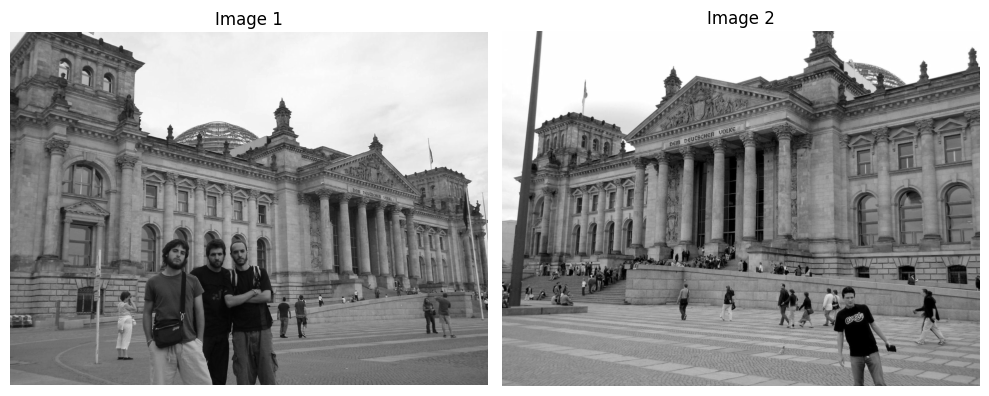

In [ ]:
# Show side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# a_path1 = '/kaggle/input/amrf-output/sample_amrf_output/2163367105_090a4a24b7_o_amrf_graph.pkl'
a_path = '/kaggle/input/amrf-output/sample_amrf_output/205952007_62674a854f_o_amrf_graph.pkl'
a_path2 = '/kaggle/input/amrf-output/sample_amrf_output/152265952_c8b3d72337_o_amrf_graph.pkl'

# amrf1 = torch.load(a_path1)  # Or use pickle.load()
# amrf2 = torch.load(a_path2)
import pickle

# Open with pickle
with open(a_path1, 'rb') as f:
    amrf1 = pickle.load(f)

with open(a_path2, 'rb') as f:
    amrf2 = pickle.load(f)


# 2. Extract region crops
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

crops1 = extract_region_crops(image1, amrf1, transform)
crops2 = extract_region_crops(image2, amrf2, transform)

# 3. Compute distance matrix
distance_matrix, node_list1, node_list2 = compute_distance_matrix(model, crops1, crops2, device)

# 4. Find best matching
matches = match_regions(distance_matrix)

# 5. Visualize
matched_nodes1 = {i for i, j in matches}
matched_nodes2 = {j for i, j in matches}

image1_with_boxes = draw_matched_boxes(image1, amrf1, matched_nodes1, node_list1, color="green")
image2_with_boxes = draw_matched_boxes(image2, amrf2, matched_nodes2, node_list2, color="blue")

# Show or save
image1_with_boxes.save("/kaggle/working/matched_image1.jpg")
image2_with_boxes.save("/kaggle/working/matched_image2.jpg")


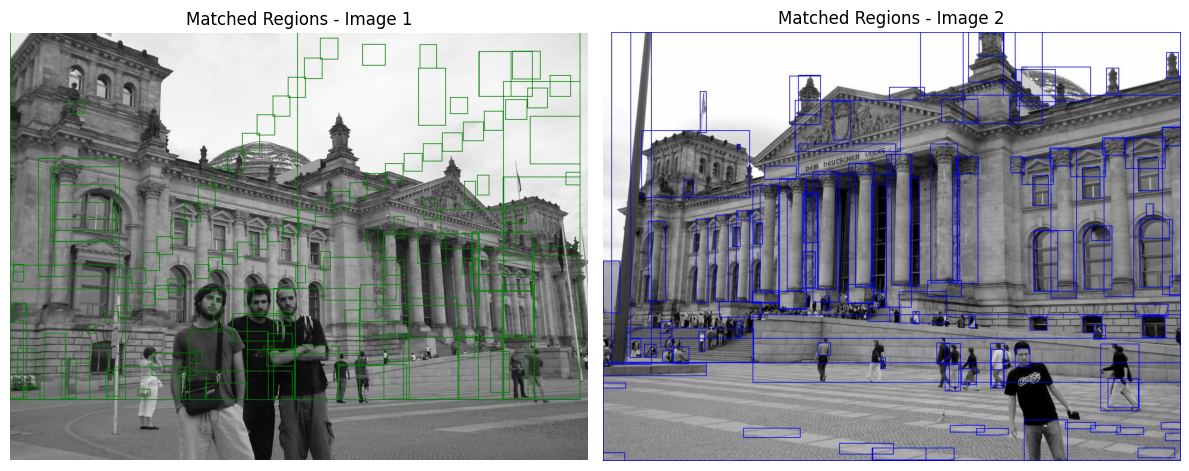

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load saved images
img1_vis = Image.open("/kaggle/working/matched_image1.jpg")
img2_vis = Image.open("/kaggle/working/matched_image2.jpg")

# Display side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img1_vis, cmap='gray')
axs[0].set_title("Matched Regions - Image 1")
axs[0].axis('off')

axs[1].imshow(img2_vis, cmap='gray')
axs[1].set_title("Matched Regions - Image 2")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
print(type(amrf1))
print(type(amrf2))


<class 'networkx.classes.graph.Graph'>
<class 'networkx.classes.graph.Graph'>


In [ ]:
# # 2. AMP
amp_results = compute_amp(aor_values)

# 3. AreaNum
area_num = compute_average_area_number(amrf1, amrf2)

print("Area Overlap Ratios (AOR) per match:", aor_values)
print("Area Matching Precision (AMP):", amp_results)
print("Average Area Number (AreaNum):", area_num)

Area Overlap Ratios (AOR) per match: [0.8006961454170427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45569620253164556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.373134328358209, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Area Matching Precision (AMP): {'AMP@0.6': 0.023622047244094488, 'AMP@0.7': 0.023622047244094488, 'AMP@0.8': 0.023622047244094488}
Average Area Number (AreaNum): 144.0


# Graph Energy Minimisation

In [ ]:
pip install PyMaxflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.4/894.4 kB 13.0 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
node_cost = 1 - distance_matrix  # Assuming distance_matrix is already in [0, 1]

In [ ]:
node_cost

array([[-0.04101336,  0.01341236, -0.22972214, ...,  0.28621566,
        -0.23300135, -0.94932795],
       [-0.03239775, -0.13047302, -0.20599079, ...,  0.2897706 ,
        -0.16546011, -0.94126165],
       [ 0.38909423,  0.56883094,  0.42261702, ...,  0.10029626,
         0.35439563, -0.23100245],
       ...,
       [ 0.01028883,  0.045542  ,  0.53426668, ..., -0.46562517,
         0.45063704,  0.36237407],
       [ 0.53695905,  0.38853574,  0.53076634, ...,  0.11800617,
         0.50744802, -0.14707863],
       [ 0.68280107,  0.32947814,  0.3430841 , ...,  0.46991795,
         0.23169017, -0.45445538]])

In [ ]:
print("Distance matrix range:", distance_matrix.min(), distance_matrix.max())

Distance matrix range: 0.1459808349609375 3.7461764812469482


In [ ]:
# normalise
node_cost = distance_matrix / np.max(distance_matrix)
print(node_cost)

[[0.2778869  0.26335856 0.3282606  ... 0.19053676 0.32913595 0.52035134]
 [0.27558706 0.30176715 0.32192578 ... 0.18958781 0.31110657 0.51819813]
 [0.16307448 0.11509577 0.15412594 ... 0.24016587 0.17233688 0.32860236]
 ...
 [0.26419235 0.25478191 0.12432231 ... 0.39123228 0.14664631 0.17020713]
 [0.12360361 0.16322356 0.12525669 ... 0.23543841 0.13148125 0.30619984]
 [0.08467271 0.17898833 0.17535637 ... 0.14149949 0.20509173 0.38825063]]


In [ ]:
node_cost.dtype

dtype('float64')

In [ ]:
node_cost.shape

(127, 161)

In [ ]:
import maxflow

g = maxflow.Graph[float]()
node_ids = {}

for i, node1 in enumerate(node_list1):
    for j, node2 in enumerate(node_list2):
        idx = (i, j)
        node_ids[idx] = g.add_nodes(1)

        cost = float(node_cost[i, j])  # This guarantees a pure Python float
        g.add_tedge(node_ids[idx], cost, 1.0 - cost)


<ipython-input-71-779e31c02691>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g.add_tedge(node_ids[idx], cost, 1.0 - cost)


# Siamese Network on 850 img pairs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

# Define Contrastive Loss
def contrastive_loss(distance, label, margin=1.0):
    loss = label * torch.pow(distance, 2) + (1 - label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    return torch.mean(loss)


class SiameseDataset(Dataset):
    def __init__(self, pairs_file, root_folder, transform=None):
        self.pairs = []
        self.root_folder = root_folder
        self.transform = transform

        with open(pairs_file, "r") as f:
            for line in f:
                img1, img2, label = line.strip().split()
                self.pairs.append((img1, img2, int(label)))

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]
        full_img1 = os.path.join(self.root_folder, img1_path)
        full_img2 = os.path.join(self.root_folder, img2_path)

        # img1 = safe_load_image(full_img1)
        # img2 = safe_load_image(full_img2)

        img1 = Image.open(full_img1).convert("L")
        img2 = Image.open(full_img2).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(float(label), dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)


In [ ]:
# optimised siamese network
# with batch normalisation, dropout and Smaller Feature Map

import torch
import torch.nn as nn
import torch.nn.functional as F

class OptimizedSiameseNetwork(nn.Module):
    def __init__(self, input_size=(400, 296)):
        super(OptimizedSiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batch Norm speeds up convergence
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((4, 4))  # Reducing final feature size for efficiency
        )

        # Compute flattened size dynamically
        sample_input = torch.zeros(1, 1, *input_size)
        sample_output = self.cnn(sample_input)
        flattened_size = sample_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(512, 128)  # Smaller embedding size for efficiency
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = F.pairwise_distance(output1, output2, keepdim=True)  # Keep dim for easy FC processing
        return distance


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((400, 296)),
    transforms.ToTensor()
])

# Load dataset from pairs.txt (corrected root path)
dataset = SiameseDataset(
    pairs_file="/kaggle/input/pairs-data/pairs.txt",
    root_folder="/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2",
    transform=transform
)
dataloader = DataLoader(dataset, shuffle=True, batch_size=8)

# Initialize model and optimizer
model = OptimizedSiameseNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# device = xm.xla_device()
# model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        distance = model(img1, img2)
        loss = contrastive_loss(distance, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

print("Training Complete!")

Epoch [1/30], Loss: 0.4944
Epoch [2/30], Loss: 0.3132
Epoch [3/30], Loss: 0.3110
Epoch [4/30], Loss: 0.3187
Epoch [5/30], Loss: 0.3147
Epoch [6/30], Loss: 0.3183
Epoch [7/30], Loss: 0.3190
Epoch [8/30], Loss: 0.3117
Epoch [9/30], Loss: 0.3141
Epoch [10/30], Loss: 0.3146
Epoch [11/30], Loss: 0.3440
Epoch [12/30], Loss: 0.3133
Epoch [13/30], Loss: 0.3161
Epoch [14/30], Loss: 0.3145
Epoch [15/30], Loss: 0.3150
Epoch [16/30], Loss: 0.3152
Epoch [17/30], Loss: 0.3107
Epoch [18/30], Loss: 0.3144
Epoch [19/30], Loss: 0.3159
Epoch [20/30], Loss: 0.3102
Epoch [21/30], Loss: 0.3111
Epoch [22/30], Loss: 0.3139
Epoch [23/30], Loss: 0.3113
Epoch [24/30], Loss: 0.3127
Epoch [25/30], Loss: 0.3108
Epoch [26/30], Loss: 0.3124
Epoch [27/30], Loss: 0.2872
Epoch [28/30], Loss: 0.2719
Epoch [29/30], Loss: 0.2724
Epoch [30/30], Loss: 0.2669
Training Complete!


> Evaluation

In [ ]:
# Reuse transform and device
eval_dataset = SiameseDataset(
    pairs_file="/kaggle/input/pairs-data/pairs.txt",
    root_folder="/kaggle/input/megadepth-v1-p2/MegaDepth_v1_p2",
    transform=transform
)
eval_loader = DataLoader(eval_dataset, shuffle=False, batch_size=8)


In [ ]:
import torch.nn.functional as F

def get_predictions_and_labels(dataloader, model, device):
    model.eval()
    all_labels = []
    all_distances = []

    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2 = img1.to(device), img2.to(device)
            label = label.to(device)

            emb1 = model.forward_once(img1)
            emb2 = model.forward_once(img2)
            distance = F.pairwise_distance(emb1, emb2)

            all_distances.extend(distance.cpu().numpy())
            all_labels.extend(label.cpu().numpy().flatten())

    return all_labels, all_distances


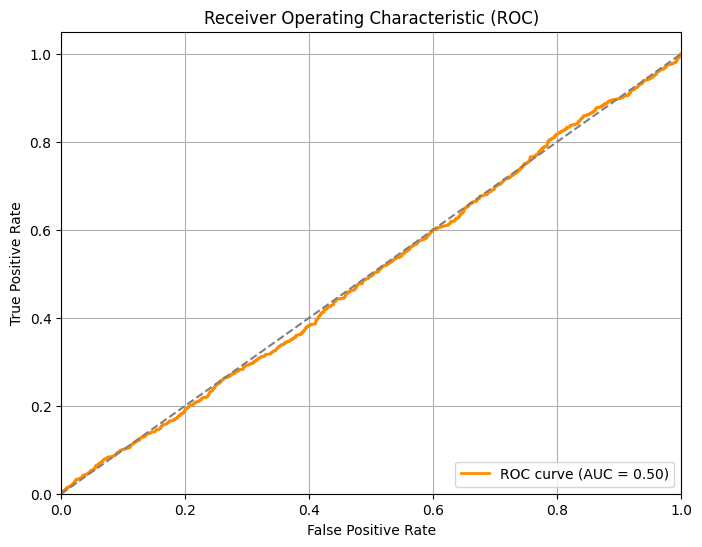

AUC: 0.4963


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels and distances
true_labels, distances = get_predictions_and_labels(eval_loader, model, device)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, distances)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"AUC: {roc_auc:.4f}")
